## Summary

The goal of this guide is to explore some of the main `scikit-learn` tools on a single practical task: analyzing a collection of text documents (newsgroups posts) on twenty different topics.

In this section we will see how to:
 - load the file contents and the categories
 - extract feature vectors suitable for machine learning
 - train a linear model to perform categorization
 - use a grid search strategy to find a good configuration of both the feature extraction components and the classifier

The dataset is called “Twenty Newsgroups”. Here is the official description, quoted from the [website](http://qwone.com/~jason/20Newsgroups/):

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

In the following we will use the built-in dataset loader for 20 newsgroups from scikit-learn. Alternatively, it is possible to download the dataset manually from the website and use the sklearn.datasets.load_files function by pointing it to the 20news-bydate-train sub-folder of the uncompressed archive folder.

In order to get faster execution times for this first example we will work on a partial dataset with only 4 categories out of the 20 available in the dataset:

## Import libraries

In [33]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import set_config
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             roc_auc_score,
                             confusion_matrix,
                            )
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold

from wordcloud import WordCloud

set_config(display="diagram", print_changed_only=False)


/Users/mouslydiaw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load data

In [2]:
categories = ['alt.atheism',
              'soc.religion.christian',
              'comp.graphics',
              'sci.med'
             ]

# We can now load the list of files matching those categories as follows:
twenty_train = fetch_20newsgroups(subset='train',
                                  categories=categories, 
                                  shuffle=True,
                                  random_state=42,
                                 )

In [3]:
LABELS = twenty_train.target_names

In [4]:
data = pd.DataFrame({"text": twenty_train.data,
                     "target": twenty_train.target
                    })

print(f"Shape of data: {data.shape}")

Shape of data: (2257, 2)


In [5]:
data.head()

,text,target
0,From: sd345@city.ac.uk (Michael Collier)\nSubj...,1
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...,1
2,From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...,3
3,From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...,3
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3


In [6]:
# It is possible to get back the category names as follows

data["target_name"] = data.target.map(lambda val: LABELS[val])
data.head()

,text,target,target_name
0,From: sd345@city.ac.uk (Michael Collier)\nSubj...,1,comp.graphics
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...,1,comp.graphics
2,From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...,3,soc.religion.christian
3,From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...,3,soc.religion.christian
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2257 entries, 0 to 2256
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         2257 non-null   object
 1   target       2257 non-null   int64 
 2   target_name  2257 non-null   object
dtypes: int64(1), object(2)
memory usage: 53.0+ KB


In [8]:
data.describe(include="all")

,text,target,target_name
count,2257,2257.000000,2257
unique,2257,NaN,4
top,From: spp@zabriskie.berkeley.edu (Steve Pope)\...,NaN,soc.religion.christian
freq,1,NaN,599
mean,NaN,1.581303,NaN
std,NaN,1.095472,NaN
min,NaN,0.000000,NaN
25%,NaN,1.000000,NaN
50%,NaN,2.000000,NaN
75%,NaN,3.000000,NaN


In [9]:
# Let’s print the first lines of the first loaded file:
print(data.loc[0, "text"])

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.



## Data exploration/viz

### Target analysis

In [10]:
label_distribution = data[["target", "target_name"]].value_counts()
label_distribution

target  target_name           
3       soc.religion.christian    599
2       sci.med                   594
1       comp.graphics             584
0       alt.atheism               480
dtype: int64

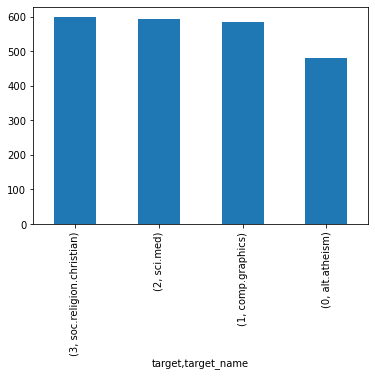

In [11]:
label_distribution.plot(kind="bar", );

### Word frequency

In [12]:
# Create a word_cloud from words and frequencies.

# get all verbatim
all_text = " ".join(data.text.str.lower())
words_frequency = Counter(all_text.split())

In [13]:
words_frequency.most_common(n=30)

[('the', 28956),
 ('of', 17381),
 ('to', 16419),
 ('a', 12808),
 ('and', 12356),
 ('is', 11716),
 ('in', 10577),
 ('that', 9922),
 ('i', 8670),
 ('it', 6239),
 ('for', 5712),
 ('you', 5199),
 ('>', 5077),
 ('not', 4804),
 ('be', 4758),
 ('are', 4565),
 ('this', 4406),
 ('have', 4113),
 ('as', 3833),
 ('with', 3518),
 ('on', 3514),
 ('but', 3204),
 ('or', 3081),
 ('if', 2976),
 ('was', 2727),
 ('by', 2448),
 ('we', 2426),
 ('can', 2363),
 ('from', 2356),
 ('from:', 2342)]

In [14]:
# get list of stopwords
stopwords_nltk = set(stopwords.words('english'))

def display_wordcloud(corpus, title=""):
    plt.figure(figsize=(10, 5))
    wc = WordCloud(background_color="white",
                   max_words=1000,
                   colormap='hsv',
                   stopwords=stopwords_nltk,
                   collocations=False)
    # generate word cloud
    # wc.generate_from_frequencies(words_frequency)
    wc.generate_from_text(corpus)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis("off");

In [15]:
display_wordcloud(corpus=all_text)

NameError: name 'WordCloud' is not defined

<Figure size 720x360 with 0 Axes>

In [ ]:
# wordcloud by target
data.groupby("target_name").apply(
    lambda group: display_wordcloud(" ".join(group.text), title=group.target_name.unique()))

## Modeling

**1- Preprocessing**

    a. Data Cleaning
    b. Vectorizer: Tf-idf; word embeddings, ...

**2- Models**

We will benchmark the 6 models below (supervised learning: classification) in order to choice the best:
    
    1. Logistic regression
    2. Multinomial Naive Bayes
    3. Perceptron
    4. Random Forest
   
We use:

- **Pipeline** : apply intermediate steps a list of transforms and a final estimator.

- **Cross validation** : evaluate estimator performance to avoid overfitting or underfitting
   
- __GridSearch__ : tun the best parameters for each model 

**4- Performance metrics**
\begin{equation*}
real_{value}  
\begin{vmatrix}
&\mathbf{predict} &\\
 & + &  -  \\
\hline \\
+ & T_p & F_n  \\
- & F_p & T_n
\end{vmatrix}
\end{equation*} 

- **[Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)** : $   \frac{T_P + T_n}{N} $  avec $ N =   T_p + F_n  + F_p + T_n $
    
- **[Précision](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)**: $ P =  \frac{T_P}{T_p + F_p} $
    
- **[Recall](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)**: $ R =  \frac{T_P}{T_p + F_n} $
- **[f1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)** : $ f_1 =  2 \frac{P \times R}{P + R} $

**Meta metrics**

- **`Micro average`**
    -  precision: $\frac{\sum_{i=1}^KT_P^i}{\sum_{i=1}^K (T_p^i + F_p^i)}$
    
    -  recall: $\frac{\sum_{i=1}^KT_P^i}{\sum_{i=1}^K (T_p^i + F_n^i)}$


- **`Macro average`**
    -  precision $\frac{\sum_{i=1}^KP^i}{K}$
    
    -  recall: $\frac{\sum_{i=1}^KR^i}{K}$


- **`Weighted average`**
    -  precision: $\frac{\sum_{i=1}^K n_iP^i}{N}$
    
    -  recall: $\frac{\sum_{i=1}^K n_iR^i}{N}$

The best model is the one with the highest values !

### Text preprocessing

#### Define preprocessing function

In [16]:
def preprocess_text(text, language="english", stopwords=None, normalizer="stem"):
    
    valid_normalizer = (None, "stem", "lemma")
    if not normalizer in valid_normalizer:
        raise ValueError(f"`normalizer` must be in `{valid_normalizer}`")
    # lower case
    text = text.lower()
    
    # delete html balise
    # We can also use BeautifulSoup package to get the text from HTML document
    text = re.sub(re.compile('<.*?>'), '', text)
    
    # remove url
    text = re.sub(r'(http|www)\S*', '', text)

    # delete email
    text = re.sub(r"\S*@\S*\s*", "", text)
    
    # delete special character
    text = re.sub(r'[^\w\s]', '', text)
    
    # delete number
    text = re.sub(r'[0-9]+','', text).strip()
    
    # tokenizer 
    text_tokens = word_tokenize(text)
    
    # remove stopword
    if isinstance(stopwords, (set, list, tuple)):
        # split sentence
        text_tokens = [word for word in text_tokens if word not in stopwords]
    # stem string: snowball stemmer
    if normalizer == "stem":
        stemmer = SnowballStemmer(language, ignore_stopwords=True)
        text_tokens = [stemmer.stem(wrd) for wrd in text_tokens]
    elif normalizer == "lemma":
        lemmatizer = WordNetLemmatizer()
        text_tokens = [lemmatizer.lemmatize(wrd) for wrd in text_tokens]
         
    return " ".join(text_tokens)

In [17]:
# test preprocessing
sentence = data.text.iloc[0]
sentence

'From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n'

In [18]:
# without delete stop word et normalizer
preprocess_text(sentence, stopwords=None, normalizer=None)

'from michael collier subject converting images to hp laserjet iii nntppostinghost hampton organization the city university lines does anyone know of a good way standard pc applicationpd utility to convert tifimgtga files into laserjet iii format we would also like to do the same converting to hpgl hp plotter files please email any response is this the correct group thanks in advance michael michael collier programmer the computer unit email the city university tel x london fax ecv hb'

In [19]:
# delete stop words in text
preprocess_text(sentence, stopwords=stopwords_nltk, normalizer=None)

'michael collier subject converting images hp laserjet iii nntppostinghost hampton organization city university lines anyone know good way standard pc applicationpd utility convert tifimgtga files laserjet iii format would also like converting hpgl hp plotter files please email response correct group thanks advance michael michael collier programmer computer unit email city university tel x london fax ecv hb'

In [20]:
# normalizer with stemmer
preprocess_text(sentence, stopwords=stopwords_nltk, normalizer="stem")

'michael collier subject convert imag hp laserjet iii nntppostinghost hampton organ citi univers line anyon know good way standard pc applicationpd util convert tifimgtga file laserjet iii format would also like convert hpgl hp plotter file pleas email respons correct group thank advanc michael michael collier programm comput unit email citi univers tel x london fax ecv hb'

In [21]:
# normalize without lemmatizer
preprocess_text(sentence, stopwords=stopwords_nltk, normalizer="lemma")

'michael collier subject converting image hp laserjet iii nntppostinghost hampton organization city university line anyone know good way standard pc applicationpd utility convert tifimgtga file laserjet iii format would also like converting hpgl hp plotter file please email response correct group thanks advance michael michael collier programmer computer unit email city university tel x london fax ecv hb'

#### Add new column for sanitizing

In [22]:
# add new column for sanitizing
data["text_sanitize"] = data.text.apply(preprocess_text, stopwords=stopwords_nltk, normalizer="stem")

In [23]:
data.head()

,text,target,target_name,text_sanitize
0,From: sd345@city.ac.uk (Michael Collier)\nSubj...,1,comp.graphics,michael collier subject convert imag hp laserj...
1,From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\...,1,comp.graphics,aniruddha b deglurkar subject help split trim ...
2,From: djohnson@cs.ucsd.edu (Darin Johnson)\nSu...,3,soc.religion.christian,darin johnson subject harrass work could use p...
3,From: s0612596@let.rug.nl (M.M. Zwart)\nSubjec...,3,soc.religion.christian,mm zwart subject cathol church poland organ fa...
4,From: stanly@grok11.columbiasc.ncr.com (stanly...,3,soc.religion.christian,stan subject elder brother organ ncr corp colu...


### Extracting features from text files

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.



**Bags of words**

The most intuitive way to do so is to use a bags of words representation:

 - Assign a fixed integer id to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).

 - For each document `#i`, count the number of occurrences of each word w and store it in `X[i, j]` as the value of feature `#j` where `j` is the index of word w in the dictionary.
 
Fortunately, **most values in X will be zeros** since for a given document less than a few thousand distinct words will be used. 

Different Methods to vectorize a corpus of documents:
 - NLTK
 - spaCy
 - Gensim
 - fastText

#### Count vectorizer
[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) supports counts of N-grams of words or consecutive characters. Once fitted, the vectorizer has built a dictionary of feature indices:

In [24]:
# get all documents (corpus)
corpus = data.text_sanitize
target = data.target

In [25]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)
X_train_counts.shape


(2257, 23605)

In [26]:
count_vect.vocabulary_.get('algorithm')

896

#### From occurrences to frequencies

Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.


In [27]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(corpus)
X_train_tfidf.shape

(2257, 23605)

#### Topic modeling

In [ ]:
clf = LDA()
clf.fit(X_train_tfidf, target)

In [ ]:
pyLDAvis.graphlab.prepare(topic_model, bows)


### Classifier

#### Naive classifier

##### Training

In [132]:
clf = MultinomialNB().fit(X_train_tfidf, target)

In [135]:
X_new_counts

<2x23605 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

##### Prediction

To try to predict the outcome on a new document we need to extract the features using almost the same feature extracting chain as before. The difference is that we call `transform` instead of `fit_transform` on the transformers, since they have already been fit to the training set:

In [138]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']

X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_vectorizer.transform(docs_new)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print(f"{doc} => {LABELS[category]}")

God is love => soc.religion.christian
OpenGL on the GPU is fast => comp.graphics


#### Building a pipeline


##### Training

In order to make the vectorizer => classifier easier to work with, `scikit-learn` provides a Pipeline class that behaves like a compound classifier:

In [184]:
mnb_clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB()),
])
mnb_clf_pipe

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

The names vectorizer and classifier are arbitrary. We will use them to perform grid search for suitable hyperparameters below. We can now train the model with a single command:

In [185]:
mnb_clf_pipe.fit(corpus, target)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

##### Prediction

In [173]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = mnb_clf_pipe.predict(docs_test)

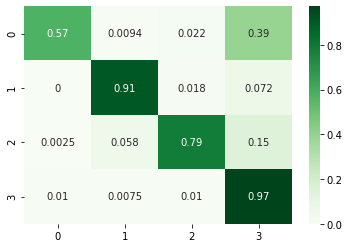

In [176]:
sns.heatmap(confusion_matrix(twenty_test.target, predicted, normalize="true"),
           annot=True, fmt='.2g', cmap="Greens");

In [174]:
print(classification_report(predicted, twenty_test.target, target_names=twenty_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.57      0.97      0.72       188
         comp.graphics       0.91      0.92      0.92       383
               sci.med       0.79      0.95      0.86       330
soc.religion.christian       0.97      0.64      0.77       601

              accuracy                           0.82      1502
             macro avg       0.81      0.87      0.82      1502
          weighted avg       0.87      0.82      0.82      1502



### Random forest

We achieved 82% accuracy. Let’s see if we can do better with a random forest classifier, which is widely regarded as one of the best text classification algorithms (although it’s also a bit slower than naïve Bayes). We can change the learner by simply plugging a different classifier object into our pipeline:

In [157]:
rf_clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier()),
])
rf_clf_pipe

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [178]:
rf_clf_pipe.fit(corpus, target)
rf_predicted = rf_clf_pipe.predict(docs_test)

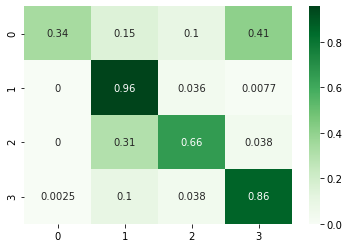

In [180]:
sns.heatmap(confusion_matrix(twenty_test.target, rf_predicted, normalize="true"),
            annot=True, fmt='.2g', cmap="Greens");

In [181]:
print(classification_report(twenty_test.target, rf_predicted,
                            target_names=twenty_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.99      0.34      0.51       319
         comp.graphics       0.64      0.96      0.77       389
               sci.med       0.81      0.66      0.73       396
soc.religion.christian       0.70      0.86      0.77       398

              accuracy                           0.72      1502
             macro avg       0.78      0.70      0.69      1502
          weighted avg       0.77      0.72      0.70      1502



### Optimization

#### Parameter tuning using grid search

In [186]:
mnb_clf_pipe

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [192]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [246]:
grid_params = {
    "vectorizer__max_df": (0.75, 0.9, 1.0),
    "vectorizer__min_df": (0.001, 0.01, 0.05),
    'vectorizer__use_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2'),
    # classifier hyperparameters
    'classifier__alpha': (1e-2, 1e-3),
    'classifier__fit_prior': [True, False],
}

# stratified cross validate
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

gs_clf = GridSearchCV(mnb_clf_pipe, grid_params, cv=skf, n_jobs=-1, verbose=1, scoring="f1_weighted")

In [199]:
%%time
gs_clf = gs_clf.fit(corpus,target)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
CPU times: user 4.57 s, sys: 961 ms, total: 5.53 s
Wall time: 2min 50s


In [203]:
print(f"Best f1 score: {gs_clf.best_score_}")
best_param = gs_clf.best_params_
print(f"\nBest parameters: \n{best_param}")

Best f1 score: 0.974272804385451

Best parameters: 
{'classifier__alpha': 0.001, 'classifier__fit_prior': False, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 0.001, 'vectorizer__norm': 'l2', 'vectorizer__use_idf': False}


In [205]:
pd.DataFrame(gs_clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__fit_prior,param_vectorizer__max_df,param_vectorizer__min_df,param_vectorizer__norm,param_vectorizer__use_idf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.785549,0.107785,0.202326,0.047937,0.01,True,0.5,0.001,l1,True,"{'classifier__alpha': 0.01, 'classifier__fit_p...",0.959756,0.966670,0.927991,0.953244,0.955413,0.952615,0.013138,73
1,1.069600,0.087738,0.272268,0.040898,0.01,True,0.5,0.001,l1,False,"{'classifier__alpha': 0.01, 'classifier__fit_p...",0.936353,0.950769,0.904055,0.927613,0.941795,0.932117,0.015920,82
2,0.803183,0.102691,0.255786,0.073591,0.01,True,0.5,0.001,l2,True,"{'classifier__alpha': 0.01, 'classifier__fit_p...",0.973419,0.977884,0.966712,0.962269,0.977817,0.971620,0.006203,22
3,1.005750,0.089433,0.242033,0.038215,0.01,True,0.5,0.001,l2,False,"{'classifier__alpha': 0.01, 'classifier__fit_p...",0.980014,0.977844,0.957761,0.971151,0.975613,0.972477,0.007922,12
4,0.690550,0.124991,0.169028,0.056351,0.01,True,0.5,0.01,l1,True,"{'classifier__alpha': 0.01, 'classifier__fit_p...",0.920978,0.932333,0.893010,0.916392,0.930232,0.918589,0.014066,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.599649,0.019260,0.160196,0.035439,0.001,False,1.0,0.01,l2,False,"{'classifier__alpha': 0.001, 'classifier__fit_...",0.964550,0.973464,0.946605,0.955567,0.955643,0.959166,0.009128,40
140,0.797022,0.058026,0.181154,0.023424,0.001,False,1.0,0.05,l1,True,"{'classifier__alpha': 0.001, 'classifier__fit_...",0.856215,0.911160,0.857624,0.882283,0.873722,0.876201,0.020049,97
141,0.883900,0.071038,0.233355,0.089750,0.001,False,1.0,0.05,l1,False,"{'classifier__alpha': 0.001, 'classifier__fit_...",0.869281,0.897718,0.861972,0.877740,0.873603,0.876063,0.012020,99
142,1.104608,0.069427,0.207127,0.040726,0.001,False,1.0,0.05,l2,True,"{'classifier__alpha': 0.001, 'classifier__fit_...",0.853626,0.904348,0.857599,0.884446,0.866968,0.873397,0.018771,112


In [206]:
best_param

{'classifier__alpha': 0.001,
 'classifier__fit_prior': False,
 'vectorizer__max_df': 0.5,
 'vectorizer__min_df': 0.001,
 'vectorizer__norm': 'l2',
 'vectorizer__use_idf': False}

In [237]:
mnb_clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(max_df=best_param.get("vectorizer__max_df"),
                                   min_df=best_param.get("vectorizer__min_df"),
                                   norm=best_param.get("vectorizer__norm"),
                                   use_idf=best_param.get("vectorizer__use_idf"),
                                  )),
    ('classifier', MultinomialNB(alpha=best_param.get("classifier__alpha"),
                                 fit_prior=best_param.get("classifier__fit_prior"),
                                )),
])
mnb_clf_pipe

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=0.001, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=False,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=0.001, class_prior=None,
                               fit_prior=False))],
         verbose=False)

In [242]:
y_train_pred = mnb_clf_pipe.fit(corpus, target).predict(corpus)

In [244]:
print(classification_report(target, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       480
           1       0.99      1.00      1.00       584
           2       1.00      0.99      0.99       594
           3       1.00      0.99      0.99       599

    accuracy                           1.00      2257
   macro avg       1.00      1.00      1.00      2257
weighted avg       1.00      1.00      1.00      2257



#### Cross validate

In [257]:
cv_scores = cross_validate(
            mnb_clf_pipe, corpus, target, scoring=["f1_weighted", "accuracy"],
            return_train_score=True, cv=skf, n_jobs=-1)

In [258]:
pd.DataFrame(cv_scores)

,fit_time,score_time,test_f1_weighted,train_f1_weighted,test_accuracy,train_accuracy
0,0.868076,0.133253,0.977830,0.997784,0.977876,0.997784
1,0.845692,0.143360,0.957827,0.997230,0.957965,0.997230
2,0.816650,0.139838,0.977748,0.997231,0.977827,0.997231
3,0.838765,0.120479,0.980043,0.998893,0.980044,0.998893
4,0.283354,0.059824,0.966714,0.997785,0.966741,0.997785
